In [10]:
%matplotlib inline
import os
import numpy as np
import glob
import xarray as xr
import pdb
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
#import sys
#sys.path.insert(1, '../Tools/')
import cartopy.crs as ccrs

from IPython.core.display import Video
from dea_tools.datahandling import paths_to_datetimeindex
from dea_tools.plotting import rgb, xr_animation

In [3]:
def paths_to_datetimeindex(paths, string_slice=(0, 10), form='%Y%m'):
    """
    Helper function to generate a Pandas datetimeindex object
    from dates contained in a file path string.
    Parameters
    ----------
    paths : list of strings
        A list of file path strings that will be used to extract times
    string_slice : tuple
        An optional tuple giving the start and stop position that
        contains the time information in the provided paths. These are
        applied to the basename (i.e. file name) in each path, not the
        path itself. Defaults to (0, 10).
    Returns
    -------
    A pandas.DatetimeIndex object containing a 'datetime64[ns]' derived
    from the file paths provided by `paths`.
    """
    date_strings = [os.path.basename(i)[slice(*string_slice)]
                    for i in paths]
    return pd.to_datetime(date_strings, format=form)

In [2]:
! wget -r --no-parent -A 'S_202*concentration_v3.0.tif' ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/ -P /g/data/jk72/sc0554

--2022-04-27 14:43:34--  ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/
           => ‘/g/data/jk72/sc0554/sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/.listing’
Resolving sidads.colorado.edu (sidads.colorado.edu)... 128.138.135.20
Connecting to sidads.colorado.edu (sidads.colorado.edu)|128.138.135.20|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /DATASETS/NOAA/G02135/south/monthly/geotiff ... done.
==> PASV ... done.    ==> LIST ... done.

sidads.colorado.edu     [ <=>                ]     971  --.-KB/s    in 0s      

2022-04-27 14:43:36 (70.0 MB/s) - ‘/g/data/jk72/sc0554/sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/.listing’ saved [971]

Removed ‘/g/data/jk72/sc0554/sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/.listing’.
--2022-04-27 14:43:36--  ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/01_Jan/
  

27


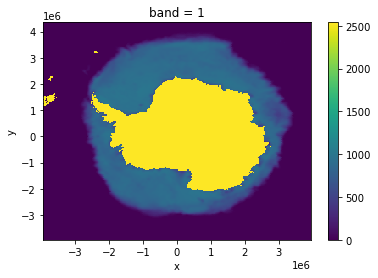

In [6]:
path = '/g/data/jk72/MIZ/sidads.colorado.edu/'

geotiff_list = []

for file in Path(path).rglob('*.tif'):
    geotiff_list.append(file)

# geotiff_list = sorted(geotiff_list, key=lambda i: int(os.path.splitext(os.path.basename(i)[2:8])[0]))
print(len(geotiff_list))
xr.open_rasterio(geotiff_list[0]).plot()

In [7]:
# Create variable used for time axis
time_var = xr.Variable('time', paths_to_datetimeindex(geotiff_list,
                                                      string_slice=(2, 8), form=))

# Load in and concatenate all individual GeoTIFFs
geotiffs_da = xr.concat([xr.open_rasterio(i) for i in geotiff_list],
                        dim=time_var)

# Covert our xarray.DataArray into a xarray.Dataset
geotiffs_ds = geotiffs_da.to_dataset('band')

# Rename the variable to a more useful name
geotiffs_ds = geotiffs_ds.rename({1: 'conc'})

# Print the output
print(geotiffs_ds)

<xarray.Dataset>
Dimensions:  (time: 27, x: 316, y: 332)
Coordinates:
  * y        (y) float64 4.338e+06 4.312e+06 4.288e+06 ... -3.912e+06 -3.938e+06
  * x        (x) float64 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * time     (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2022-03-01
Data variables:
    conc     (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    transform:      (25000.0, 0.0, -3950000.0, 0.0, -25000.0, 4350000.0)
    crs:            +init=epsg:3412
    res:            (25000.0, 25000.0)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


730
<xarray.Dataset>
Dimensions:  (time: 730, x: 1264, y: 1328)
Coordinates:
  * x        (x) float64 -3.947e+06 -3.941e+06 ... 3.941e+06 3.947e+06
  * y        (y) float64 4.347e+06 4.341e+06 4.334e+06 ... -3.941e+06 -3.947e+06
  * time     (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2020-12-31
Data variables:
    conc     (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    transform:                 (6250.0, 0.0, -3950000.0, 0.0, -6250.0, 435000...
    crs:                       +init=epsg:3412
    res:                       (6250.0, 6250.0)
    is_tiled:                  0
    nodatavals:                (nan,)
    scales:                    (1.0,)
    offsets:                   (0.0,)
    AREA_OR_POINT:             Area
    TIFFTAG_ARTIST:            University of Bremen, Gunnar Spreen [gunnar.sp...
    TIFFTAG_IMAGEDESCRIPTION:  AMSR2 sea ice concentration using the ASI algo...
    TIFFTAG_SOFTWARE:          gdal and GMT
    x#actual_range:       

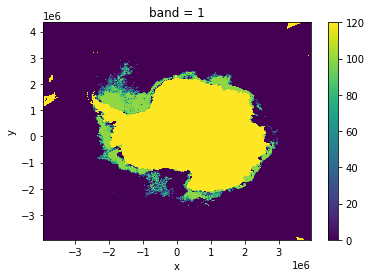

In [4]:
# for y in {2019..2020}; do for m in jan feb mar apr may jun jul aug sep oct nov dec; do wget -A .tif -r -nc -nd -np -nH -nv -e robots=off seaice.uni-bremen.de/data/amsr2/asi_daygrid_swath/s6250/$y/$m/Antarctic/; done; done

path = '/g/data/jk72/MIZ/Bremen/'
geotiff_list = []

for file in Path(path).rglob('*v5.4.tif'):
    geotiff_list.append(file)

geotiff_list = sorted(geotiff_list, key=lambda i: int(os.path.splitext(os.path.basename(i)[16:24])[0]))
print(len(geotiff_list))
xr.open_rasterio(geotiff_list[0]).plot()

# Create variable used for time axis
# %m = zero padded decimal for month
# % d = zero padded decimal for day
time_var = xr.Variable('time', paths_to_datetimeindex(geotiff_list,
                                                      string_slice=(16,24), form='%Y%m%d'))

# Load in and concatenate all individual GeoTIFFs
geotiffs_da = xr.concat([xr.open_rasterio(i) for i in geotiff_list],
                        dim=time_var)

# Covert our xarray.DataArray into a xarray.Dataset
geotiffs_ds = geotiffs_da.to_dataset('band')

# Rename the variable to a more useful name
geotiffs_ds = geotiffs_ds.rename({1: 'conc'})

# Print the output
print(geotiffs_ds)

In [4]:
# resample daily to monthly

geotiffs_ds = geotiffs_ds.resample(time="M").mean()

In [6]:
# get monthly averages

monthly_average = geotiffs_ds.groupby('time.month').mean('time')

monthly_average = monthly_average.rename_dims({'month':'time'})

AttributeError: 'AxesSubplot' object has no attribute 'coastlines'

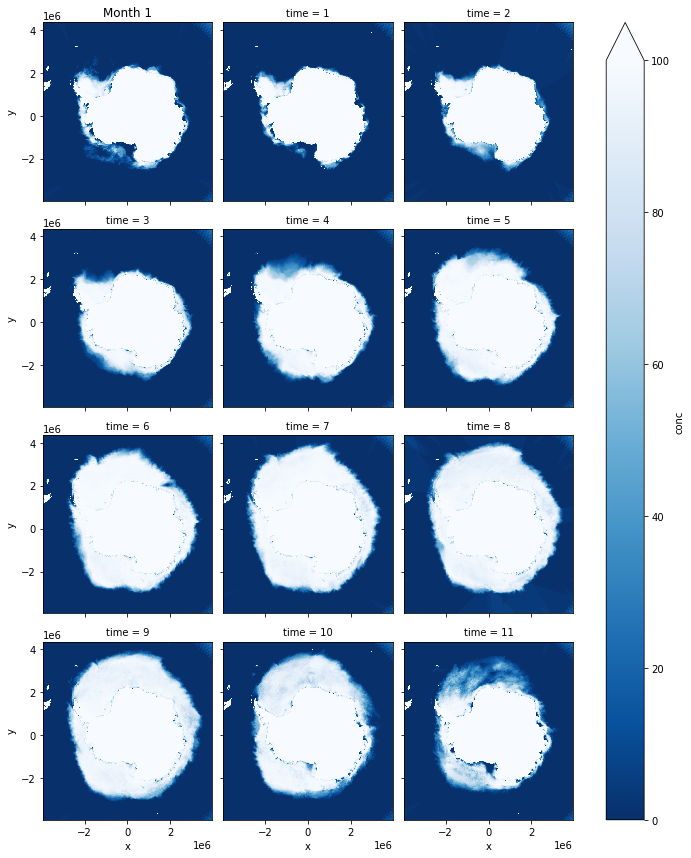

In [8]:
g = monthly_average['conc'].plot(col='time', col_wrap=3, cmap='Blues_r', vmin=0, vmax=100)

for i, ax in enumerate(g.axes.flat):

    ax.set_title(f"Month {i+1}")

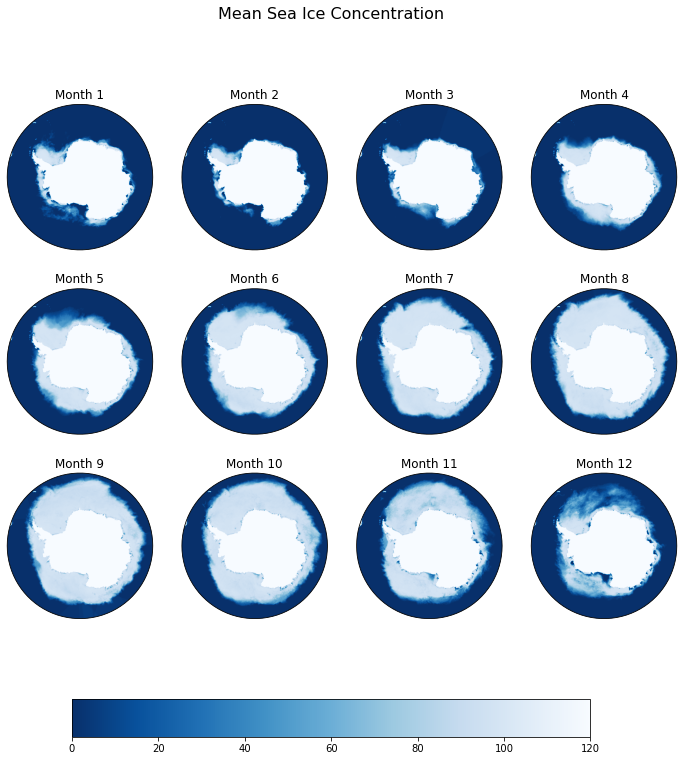

In [37]:
plt.figure(figsize=(12,13))
plt.suptitle('Mean Sea Ice Concentration', fontsize=16)

for iMonth in np.arange(0, 12):
    
    ax = plt.subplot(4,4,iMonth+1,projection=ccrs.SouthPolarStereo())
    
    toPlot=monthly_average.sel(time=iMonth)
    
    plt.imshow(
        toPlot['conc'],
        #levels=[0,.15,.80,1.00],
#         levels=np.arange(0,1.04,.1),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )

#     gl = ax.gridlines(
#         draw_labels=False, linewidth=2, color='gray', alpha=0.5, linestyle='--'
#     )

#     ax.coastlines()
    plt.title('Month ' + str(iMonth+1))
    
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.6,0.04]))
plt.show()

In [10]:
geotiffs_ds_resample = geotiffs_ds.resample(time="M", keep_attrs=True).mean()
geotiffs_ds_resample.attrs = geotiffs_ds.attrs

In [38]:
# Produce time series animation
xr_animation(ds=geotiffs_ds, 
             bands=['conc'],
             output_path='animated_timeseries.mp4',                                
             interval=100, 
             width_pixels=300,
             show_date='%b %Y')

# Plot animation
plt.close()
Video('animated_timeseries.mp4', embed=True)

AttributeError: 'NoneType' object has no attribute 'shape'